In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("TwitterStreaming").master("local").getOrCreate()

# Set up streaming

In [2]:
from pyspark.sql.types import *

schema = StructType([StructField("id", IntegerType(), True),
                     StructField("entity", StringType(), True),
                     StructField("sentiment", StringType(), True),
                     StructField("text", StringType(), True)])

In [3]:
df = (spark
      .readStream
      .schema(schema)
      .option('header', False)
      .csv("hdfs://namenode:9000//user/root/data_stream"))
     
df.isStreaming

True

# Data processing

In [4]:
from pyspark.ml import PipelineModel

model = PipelineModel.load("hdfs://namenode:9000//user/root/model/twitter_lg")

In [5]:
df = df.na.drop() 
prediction = model.transform(df)
prediction.printSchema()

root
 |-- id: integer (nullable = true)
 |-- entity: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- text: string (nullable = true)
 |-- label: double (nullable = false)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- meanWords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [6]:
from pyspark.ml.feature import IndexToString
inverter = IndexToString(inputCol="prediction", outputCol="sentimentPrediction", labels=model.stages[0].labels)
prediction = inverter.transform(prediction).select("entity", "text", "sentimentPrediction")

# Start streaming

In [7]:
query = (prediction
         .writeStream
         .outputMode('append')
         .format('memory')
         .queryName('mem_results')
         .start())

In [8]:
display(query.status)

{'message': 'Processing new data',
 'isDataAvailable': True,
 'isTriggerActive': True}

In [9]:
query.recentProgress

[{'id': '2c9c416e-983a-4ed7-ba3d-c99ecc01ed85',
  'runId': '5f0fc999-72b6-4fc4-9451-a9fad86605e0',
  'name': 'mem_results',
  'timestamp': '2024-10-31T00:31:33.757Z',
  'batchId': 0,
  'numInputRows': 0,
  'inputRowsPerSecond': 0.0,
  'processedRowsPerSecond': 0.0,
  'durationMs': {'latestOffset': 41, 'triggerExecution': 74},
  'stateOperators': [],
  'sources': [{'description': 'FileStreamSource[hdfs://namenode:9000/user/root/data_stream]',
    'startOffset': None,
    'endOffset': None,
    'latestOffset': None,
    'numInputRows': 0,
    'inputRowsPerSecond': 0.0,
    'processedRowsPerSecond': 0.0}],
  'sink': {'description': 'MemorySink', 'numOutputRows': -1}}]

In [10]:
spark.sql('show tables').show()

+---------+-----------+-----------+
|namespace|  tableName|isTemporary|
+---------+-----------+-----------+
|         |mem_results|       true|
+---------+-----------+-----------+



In [20]:
spark.sql('select * from mem_results').show(n=10)

+--------------------+--------------------+-------------------+
|              entity|                text|sentimentPrediction|
+--------------------+--------------------+-------------------+
|            Facebook|I mentioned on Fa...|         Irrelevant|
|              Amazon|BBC News - Amazon...|            Neutral|
|           Microsoft|@Microsoft Why do...|           Negative|
|               CS-GO|CSGO matchmaking ...|           Negative|
|              Google|Now the President...|            Neutral|
|                FIFA|Hi @EAHelp I’ve h...|           Negative|
|           MaddenNFL|Thank you @EAMadd...|           Positive|
|TomClancysRainbowSix|Rocket League, Se...|           Positive|
|      AssassinsCreed|my ass still knee...|           Positive|
|          CallOfDuty|FIX IT JESUS ! Pl...|           Negative|
+--------------------+--------------------+-------------------+
only showing top 10 rows



# Show results

In [13]:
import matplotlib.pyplot as plt

def countSentiments(entity = 'All'):
    sentiments = spark.sql('select * from mem_results')
    if entity == 'All':
        sentiments = sentiments.groupBy('sentimentPrediction').count()
    else:
        sentiments = sentiments.filter(sentiments.entity == entity).groupBy('sentimentPrediction').count()
    sentiments.show()
    
    labels = sentiments.select("sentimentPrediction").toPandas().values.reshape(-1)
    counts = sentiments.select("count").toPandas().values.reshape(-1)
    
    fig, ax = plt.subplots()
    ax.pie(counts, labels=labels, autopct='%1.1f%%')
    
    plt.title(entity + ' sentiments')

    return fig, ax
    #plt.show()

+-------------------+-----+
|sentimentPrediction|count|
+-------------------+-----+
|         Irrelevant|  159|
|            Neutral|  256|
|           Positive|  315|
|           Negative|  270|
+-------------------+-----+



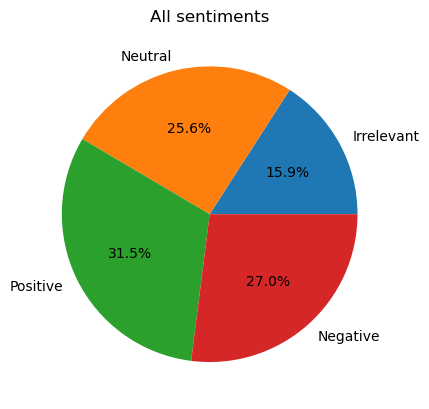

In [16]:
fig, ax = countSentiments()

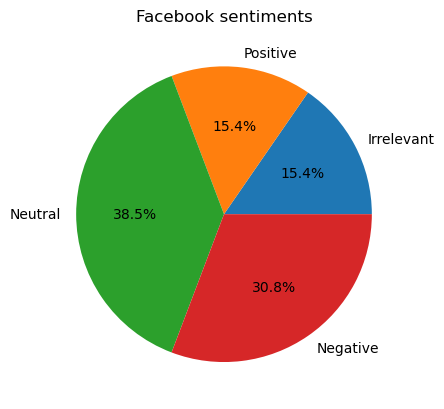

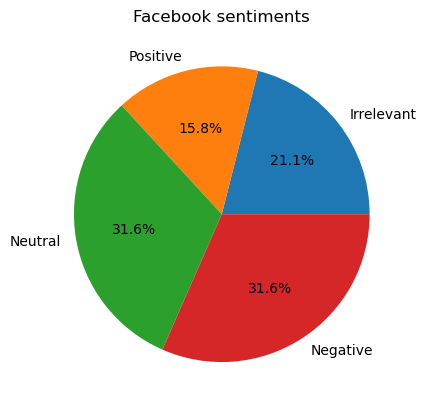

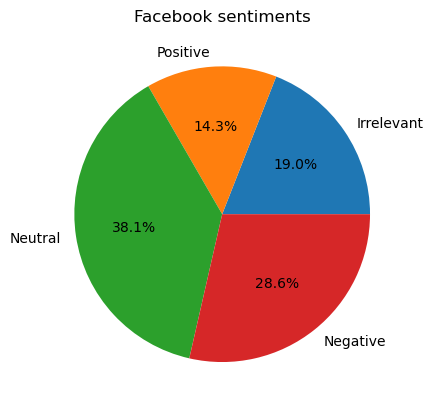

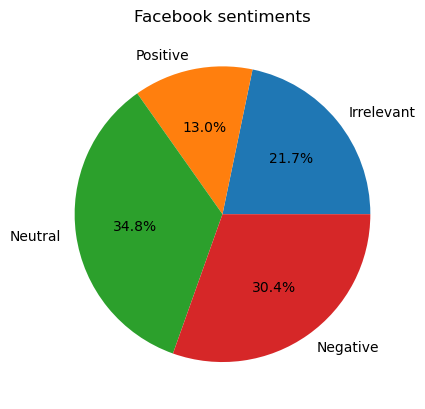

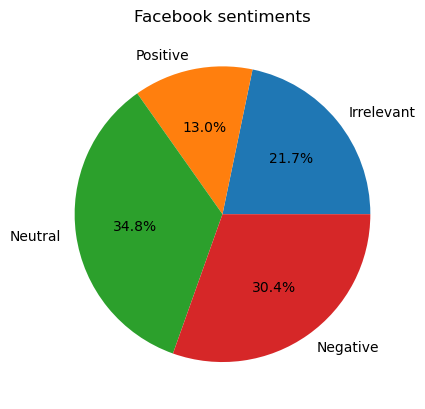

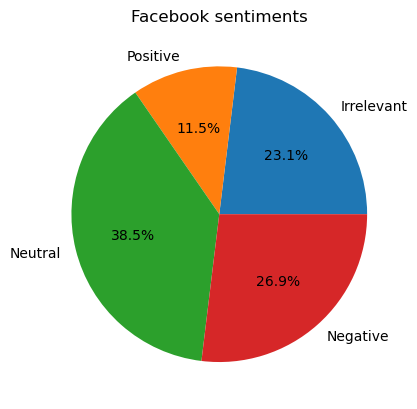

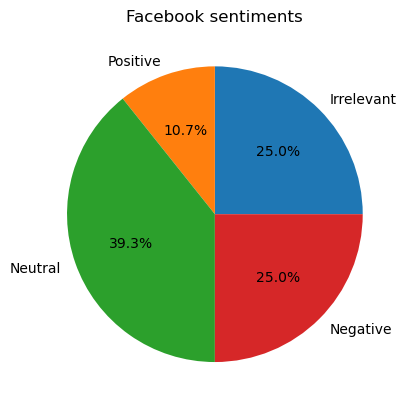

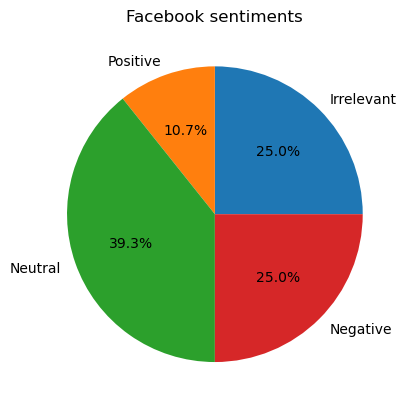

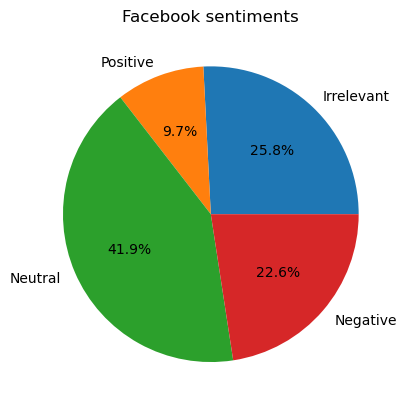

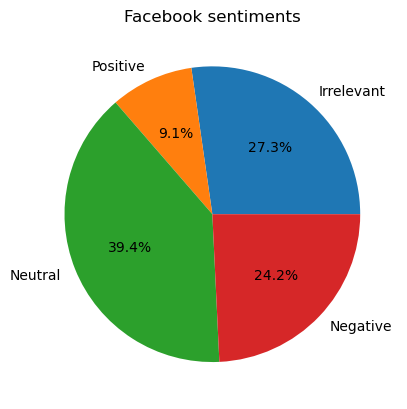

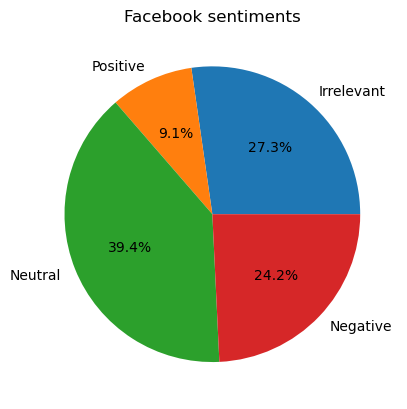

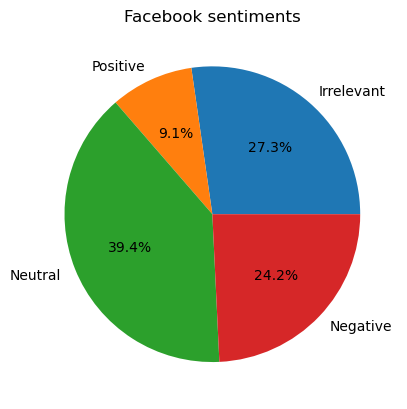

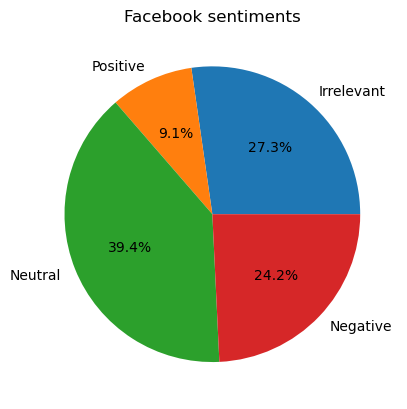

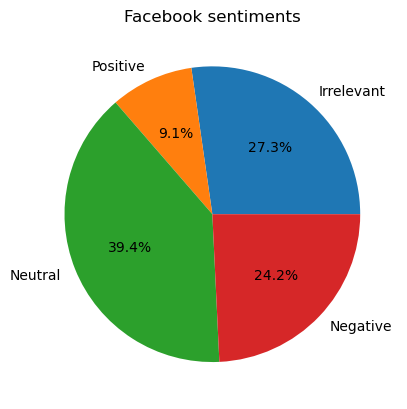

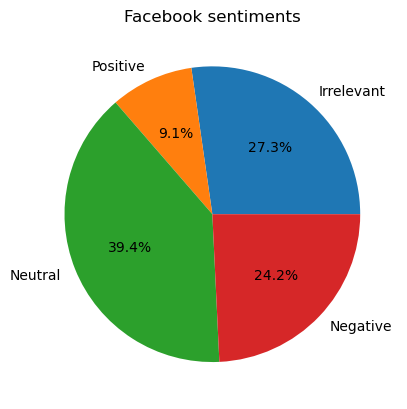

In [15]:
from IPython import display
import time

while True:
    try:
        fig, ax = countSentiments('Facebook')
        display.display(fig)
        display.clear_output(wait=True)
        time.sleep(2)
    except KeyboardInterrupt:
        break

# Stop streaming

In [9]:
query.stop()

In [10]:
display(query.status)

{'message': 'Stopped', 'isDataAvailable': False, 'isTriggerActive': False}